In [132]:
import os
from pprint import pprint
import tempfile

import datasets

import armory.data
import armory.dataset
import armory.evaluation
import armory.examples

![MSTAR 10 Targets](mstar_10_targets.png)

[Song, Haibo & Ji, Kefeng & Zhang, Yunshu & Xing, Xiang & Zou, Huanxin. (2016). Sparse Representation-Based SAR Image Target Classification on the 10-Class MSTAR Data Set. Applied Sciences. 6. 26. 10.3390/app6010026.](https://www.mdpi.com/2076-3417/6/1/26)


In [56]:
sample_dir = tempfile.TemporaryDirectory()
print(sample_dir.name)

!git clone https://github.com/benjaminlewis-afrl/SAMPLE_dataset_public $sample_dir.name

/var/folders/mx/2fq0bpm91s38j1xtwcx2_b7c0000gp/T/tmpj4p3wd3n
Cloning into '/var/folders/mx/2fq0bpm91s38j1xtwcx2_b7c0000gp/T/tmpj4p3wd3n'...
remote: Enumerating objects: 8159, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
  Receiving objects:  25% (2040/8159), 1.02 GiB | 12.71 MiB/sReceiving objects:  25% (2082/8159), 1.04 GiB | 12.99 MiB/sReceiving objects:  26% (2122/8159), 1.06 GiB | 13.72 MiB/sReceiving objects:  26% (2173/8159), 1.08 GiB | 13.80 MiB/sReceiving objects:  27% (2203/8159), 1.10 GiB | 13.72 MiB/sReceiving objects:  27% (2246/8159), 1.12 GiB | 12.70 MiB/sReceiving objects:  28% (2285/8159), 1.14 GiB | 12.17 MiB/sReceiving objects:  28% (2331/8159), 1.16 GiB | 12.75 MiB/sReceiving objects:  29% (2367/8159), 1.17 GiB | 13.39 MiB/sReceiving objects:  29% (2412/8159), 1.20 GiB | 13.28 MiB/sReceiving objects:  30% (2448/8159), 1.21 GiB | 11.19 MiB/sReceiving objects:  30% (2483/8159), 1.23 GiB | 11.40 MiB/sReceiving obje

In [72]:
data_dir = os.path.join(sample_dir.name, "png_images", "qpm", "real")

!ls $data_dir

2s1   bmp2  btr70 m1    m2    m35   m548  m60   t72   zsu23


In [79]:
raw_dataset = datasets.load_dataset('imagefolder', data_dir=data_dir)
raw_dataset

Resolving data files:   0%|          | 0/1345 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1345
    })
})

In [80]:
raw_dataset['train'].features['label'].names

['2s1', 'bmp2', 'btr70', 'm1', 'm2', 'm35', 'm548', 'm60', 't72', 'zsu23']

In [81]:
raw_dataset['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=128x128>,
 'label': 0}

In [82]:
def transforms(examples):
    examples["image"] = [image.convert("RGB") for image in examples["image"]]
    return examples

# raw_dataset.set_transform(transforms)

raw_dataset = raw_dataset.map(transforms, batched=True)

Map:   0%|          | 0/1345 [00:00<?, ? examples/s]

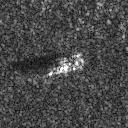

mode RGB


In [83]:
display(raw_dataset['train'][0]['image'])
print(f"mode {raw_dataset['train'][0]['image'].mode}")

In [84]:
raw_dataset['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128>,
 'label': 0}

In [85]:
train_dataset = raw_dataset['train'].train_test_split(
    test_size=3/10,
    stratify_by_column='label'
)

test_dataset = train_dataset['test'].train_test_split(
    test_size=2/3,
    stratify_by_column='label'
)

mstar_dataset = datasets.DatasetDict(
    {
        'train': train_dataset['train'],
        'valid': test_dataset['train'],
        'test': test_dataset['test']
    }
)

mstar_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 941
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 134
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 270
    })
})

In [86]:
batch_size = 16
shuffle = False

unnormalized_scale = armory.data.Scale(
    dtype=armory.data.DataType.UINT8,
    max=255,
)

mstar_dataloader = armory.dataset.ImageClassificationDataLoader(
    mstar_dataset['train'],
    dim=armory.data.ImageDimensions.CHW,
    scale=unnormalized_scale,
    image_key="image",
    label_key="label",
    batch_size=batch_size,
    shuffle=shuffle,
)

armory_dataset = armory.evaluation.Dataset(
    name="food-101",
    dataloader=mstar_dataloader,
)

armory_dataset

2024-04-06 21:44:09 2h39m24s WARNING  armory.track:_wrapper:175 Parameters with prefix ImageClassificationDataLoader have already been logged and will be overwritten. Use a unique prefix or start a new tracking context with `tracking_context` to avoid this warning.


Dataset(name='food-101', dataloader=<armory.dataset.ImageClassificationDataLoader object at 0x2cd61dd10>)

In [87]:
with tempfile.TemporaryDirectory() as d:
    mstar_path = os.path.join(d, 'mstar_10.hf')
    mstar_dataset.save_to_disk(mstar_path)
    pprint(datasets.load_from_disk(mstar_path))

Saving the dataset (0/1 shards):   0%|          | 0/941 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/134 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/270 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 941
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 134
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 270
    })
})


In [ ]:
sample_dir.cleanup()